In [1]:
import pandas as pd 
import numpy as np 

#Dichiaro il path della cartella del dataset
import os
dataset_folder = "/home/aliquodfahriam/tinyML/CMAPSS/CMAPSS"

In [2]:
#Genero i nomi per le colonne dei sensori
sensors = []
for i in range(1,23): #Nel readme dice che i sensori dovrebbero essere 26, tuttavia dai dati ne emergono soltanto 21, il 22esimo dovrebbe essere pieno di NaN,
                    #Tuttavia mettendo il range da 1 a 22 si crea un warning per cui ci sarebbe una perdita di informazione che non sarebbe desiderabile.  
    sensor = "sensor"+str(i)
    sensors.append(sensor)

print(sensors)

del i, sensor

['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21', 'sensor22']


In [3]:
train = []
test = []
names_train = ['train1', 'train2', 'train3', 'train4']
names_test = ['test1', 'test2', 'test3', 'test4']

files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('train')]
test_files = [file for file in files if file.startswith('test')]
# print(train_files)
# print(test_files)
train_files.sort()
test_files.sort()
print(train_files)
print(test_files)

colnames = ["unit_number", "time_cycle", "op_setting1", "op_setting2", "op_setting3"]

for sensor in sensors:
    colnames.append(sensor)


for file in train_files: 
    df = pd.read_csv(dataset_folder+"/"+file, delimiter=' ', index_col=False, names=colnames)
    train.append(df)

df = train[0]

print(colnames)

#df = pd.read_csv(dataset_folder+"/"+train_files[3], delimiter=' ', index_col=False, names=colnames)


['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
['unit_number', 'time_cycle', 'op_setting1', 'op_setting2', 'op_setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21', 'sensor22']


In [4]:
## Proviamo a rimuovere gli NaN dai vari dataframe per capire se c'è qualche valore fuori posto in qualche riga.

for df in train: 
    df = df.fillna(value=0, inplace=True)

df = train[0]

counter = 0
for df in train:
    counter += 1 
    value = (df['sensor22'] != 0).any()
    if value: 
        print("Ci sono valori diversi da zero nel dataframe di posto "+ str(counter))
    else:
        print("Tutti i valori sono zero nel dataframe di posto "+str(counter))

#Comprendo da questo che posso procedere a rimuovere la colonna sensor22 da tutti i dataframe in train: 
for df in train: 
    df.drop('sensor22', axis=1, inplace=True)

df = train[0]

Tutti i valori sono zero nel dataframe di posto 1
Tutti i valori sono zero nel dataframe di posto 2
Tutti i valori sono zero nel dataframe di posto 3
Tutti i valori sono zero nel dataframe di posto 4


###### Sensori con valori costanti
Nel papper in esame viene fatto notare come alcuni sensori riportino valori costanti e quindi siano inutili ai fini del nostro esame. Procediamo a verificare che ciò è vero e capiamo se è corretto eliminarli o meno

I sensori da controllare sono: 
- Numero 0
- Numero 4 
- Numero 5
- Numero 9 
- Numero 15 
- Numero 17 
- Numero 18 


Da una prima osservazione si nota come non sia possibile tracciare un modello comune per tutti i dataset di training e si debba quindi ricorrere a una preparazione dei dati più *raffinata* che tenga conto del numero di valori per ogni colonna contenente valori appartenenti ad ogni sensore. 

In [5]:
# df = train[0]
# df1 = train[1]
# df2 = train[2]
# df3 = train[3]

In [6]:
sensors.remove("sensor22")
unique_values_list = []

for dataframe in train: 
    unique_values_per_df = [] 
    
    for sensor in sensors:
       
        unique_values_frame = dataframe[sensor].unique()
        unique_values_per_df.append(unique_values_frame)
    
    unique_values_list.append(unique_values_per_df)

La variabile *unique_values_list* è composta da 4 righe, in cui ciascuna contine i valori unici di ogni dataframe. Si potrebbe quindi pensare di separare i 4 array per ottenere singolarmente i valori unici di ogni pezzo del dataset. 

Ricordiamo che questo processo è necessario per comprendere se ciò che viene affermato all'interno del paper corrisponde a verità o meno. 

Il passo successivo sarà la normalizzazione dei dataframe tramite un operatore di MinMax Normalization

In [7]:
#Attenzione! Ogni riga corrisponde ai valori unici di un sensore 
#i valori posti ad NaN sono una normale conseguenza del processo che abbiamo seguito
unique_1 = unique_values_list[0]
unique_2 = unique_values_list[1]
unique_3 = unique_values_list[2]
unique_4 = unique_values_list[3]

In [8]:
# for i in range(0,21): 
#     print(str(i)+":      "+str(unique_4[i]))

Si può notare subito come i pattern che riguardano il primo e il terzo dataset siano collegati al fatto che essi rappresentino una singola condizione delle sei possibili, mentre il secondo e il quarto dataset (essendo misti) risultino più complessi da analizzare e, di conseguenza, non ci permettono di essere sicuri nel rimuovere i sensori che abbiamo trovato. 
Per completezza allego le condizioni possibili: 


There are 6 conditions (or combinations) which the 3 operational settings can take.
- Condition 1: Altitude = 0, Mach Number = 0, TRA = 100
- Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100
- Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100
- Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60
- Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100
- Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100

Il pattern definito all'interno del paper sembra essere valido per i dataframe 0 e 2 (ovvero FD0001 e FD0003), tuttavia non lo è per i rimanenti due, di conseguenza risulta neessario sottolineare che <mark>da qui in poi supporremo che sia corretto eliminare le colonne dei sensori sopracitati e procederemo serenamente con la loro eliminazione</mark>


In [9]:
## Inseriamo la colonna RUL all'interno del dataset di train
def insertRULtrain(train_list):
    for df in train:
        #La prossim riga crea un dizionario chiamato cycles che itera per ogni "unique"
        #unit_number all'interno del dataframe e inserisce come valore il massimo dei valori
        #della colonna time_cycle
        cycles = {id_max: df[df['unit_number']==id_max]['time_cycle'].max() for id_max in df['unit_number'].unique()} 

        #la variabile ruls è una lista che contiene la colonna RUL, ovvero i valori in ordine decrescente all'interno della colonna 
        #time_cycle (a intervalli di 1, questo valore potrebbe essere modificato a piacimento modificando leggermente la funzione)
        ruls = [cycles[row[0]] - 1 if row[1] < 1 else cycles[row[0]] - row[1] for row in df.values]

        ##In versione estesa sarebbe
        # ruls = []

        # for row in df.values: 
        #     if row[1] < 1: 
        #         ruls.append(cycles[row[0]] - 1)
        #     else: 
        #         ruls.append(cycles[row[0]] - row[1])
        
        df['RUL'] = ruls

insertRULtrain(train)

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns 

Ciò che abbiamo detto in precedenza risulta particolarmente chiaro se osserviamo la differenza che intercorre tra i valori dei sensori di FD0001 e FD0002

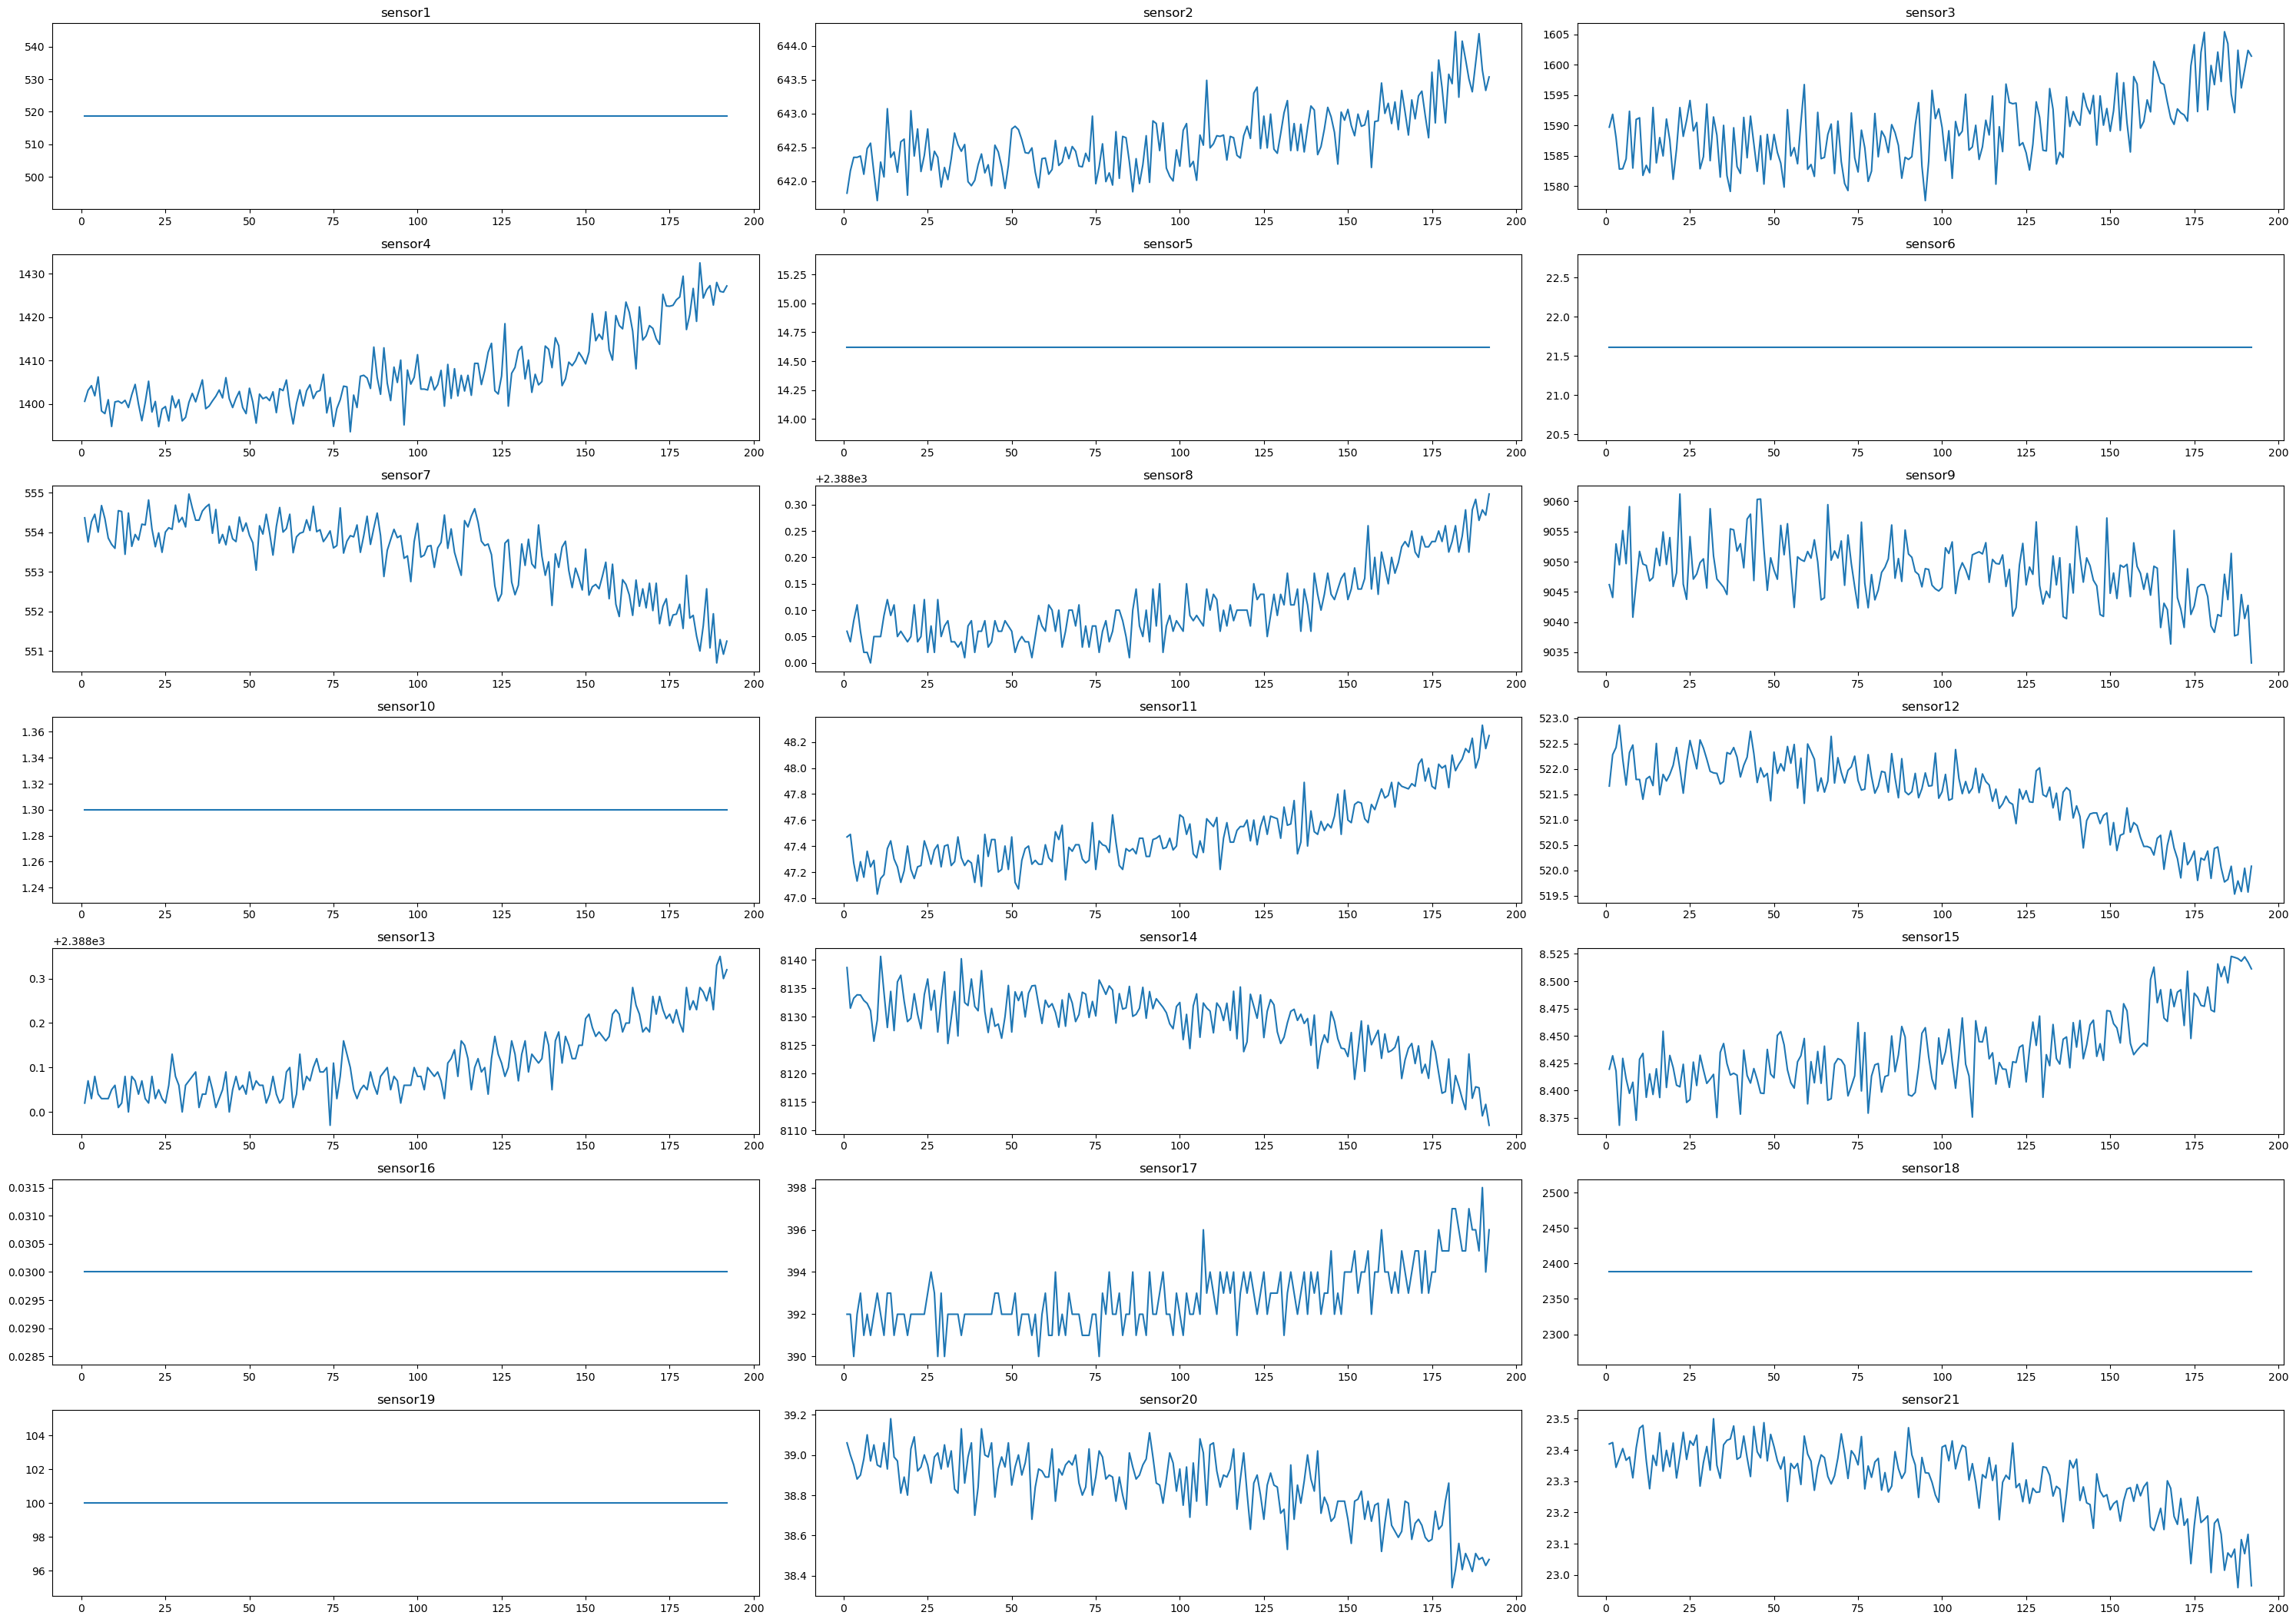

In [11]:
def plotSensors(train_list, numeroDF,unit_number, sensors): 
    #Controllo input banale
    if numeroDF < 0 or numeroDF > 3:
        print("numeroDF può andare da 0 a 3")
        return
   
   
    df = train_list[numeroDF]
    plt.figure(figsize=(30,30))
    i = 0
    for sensor in sensors: 
        plt.subplot(10, 3, i+1).set_title(sensor)
        #Il problema sta nel cercare di plottare i dati dei sensori di un unico ciclo
        sensordata = df[df['unit_number'] == unit_number]
        plt.plot(sensordata['time_cycle'],sensordata[sensor])
        i += 1
    plt.tight_layout()


#numeroDF può andare da 0 a 3 
plotSensors(train, 0, 1,sensors)

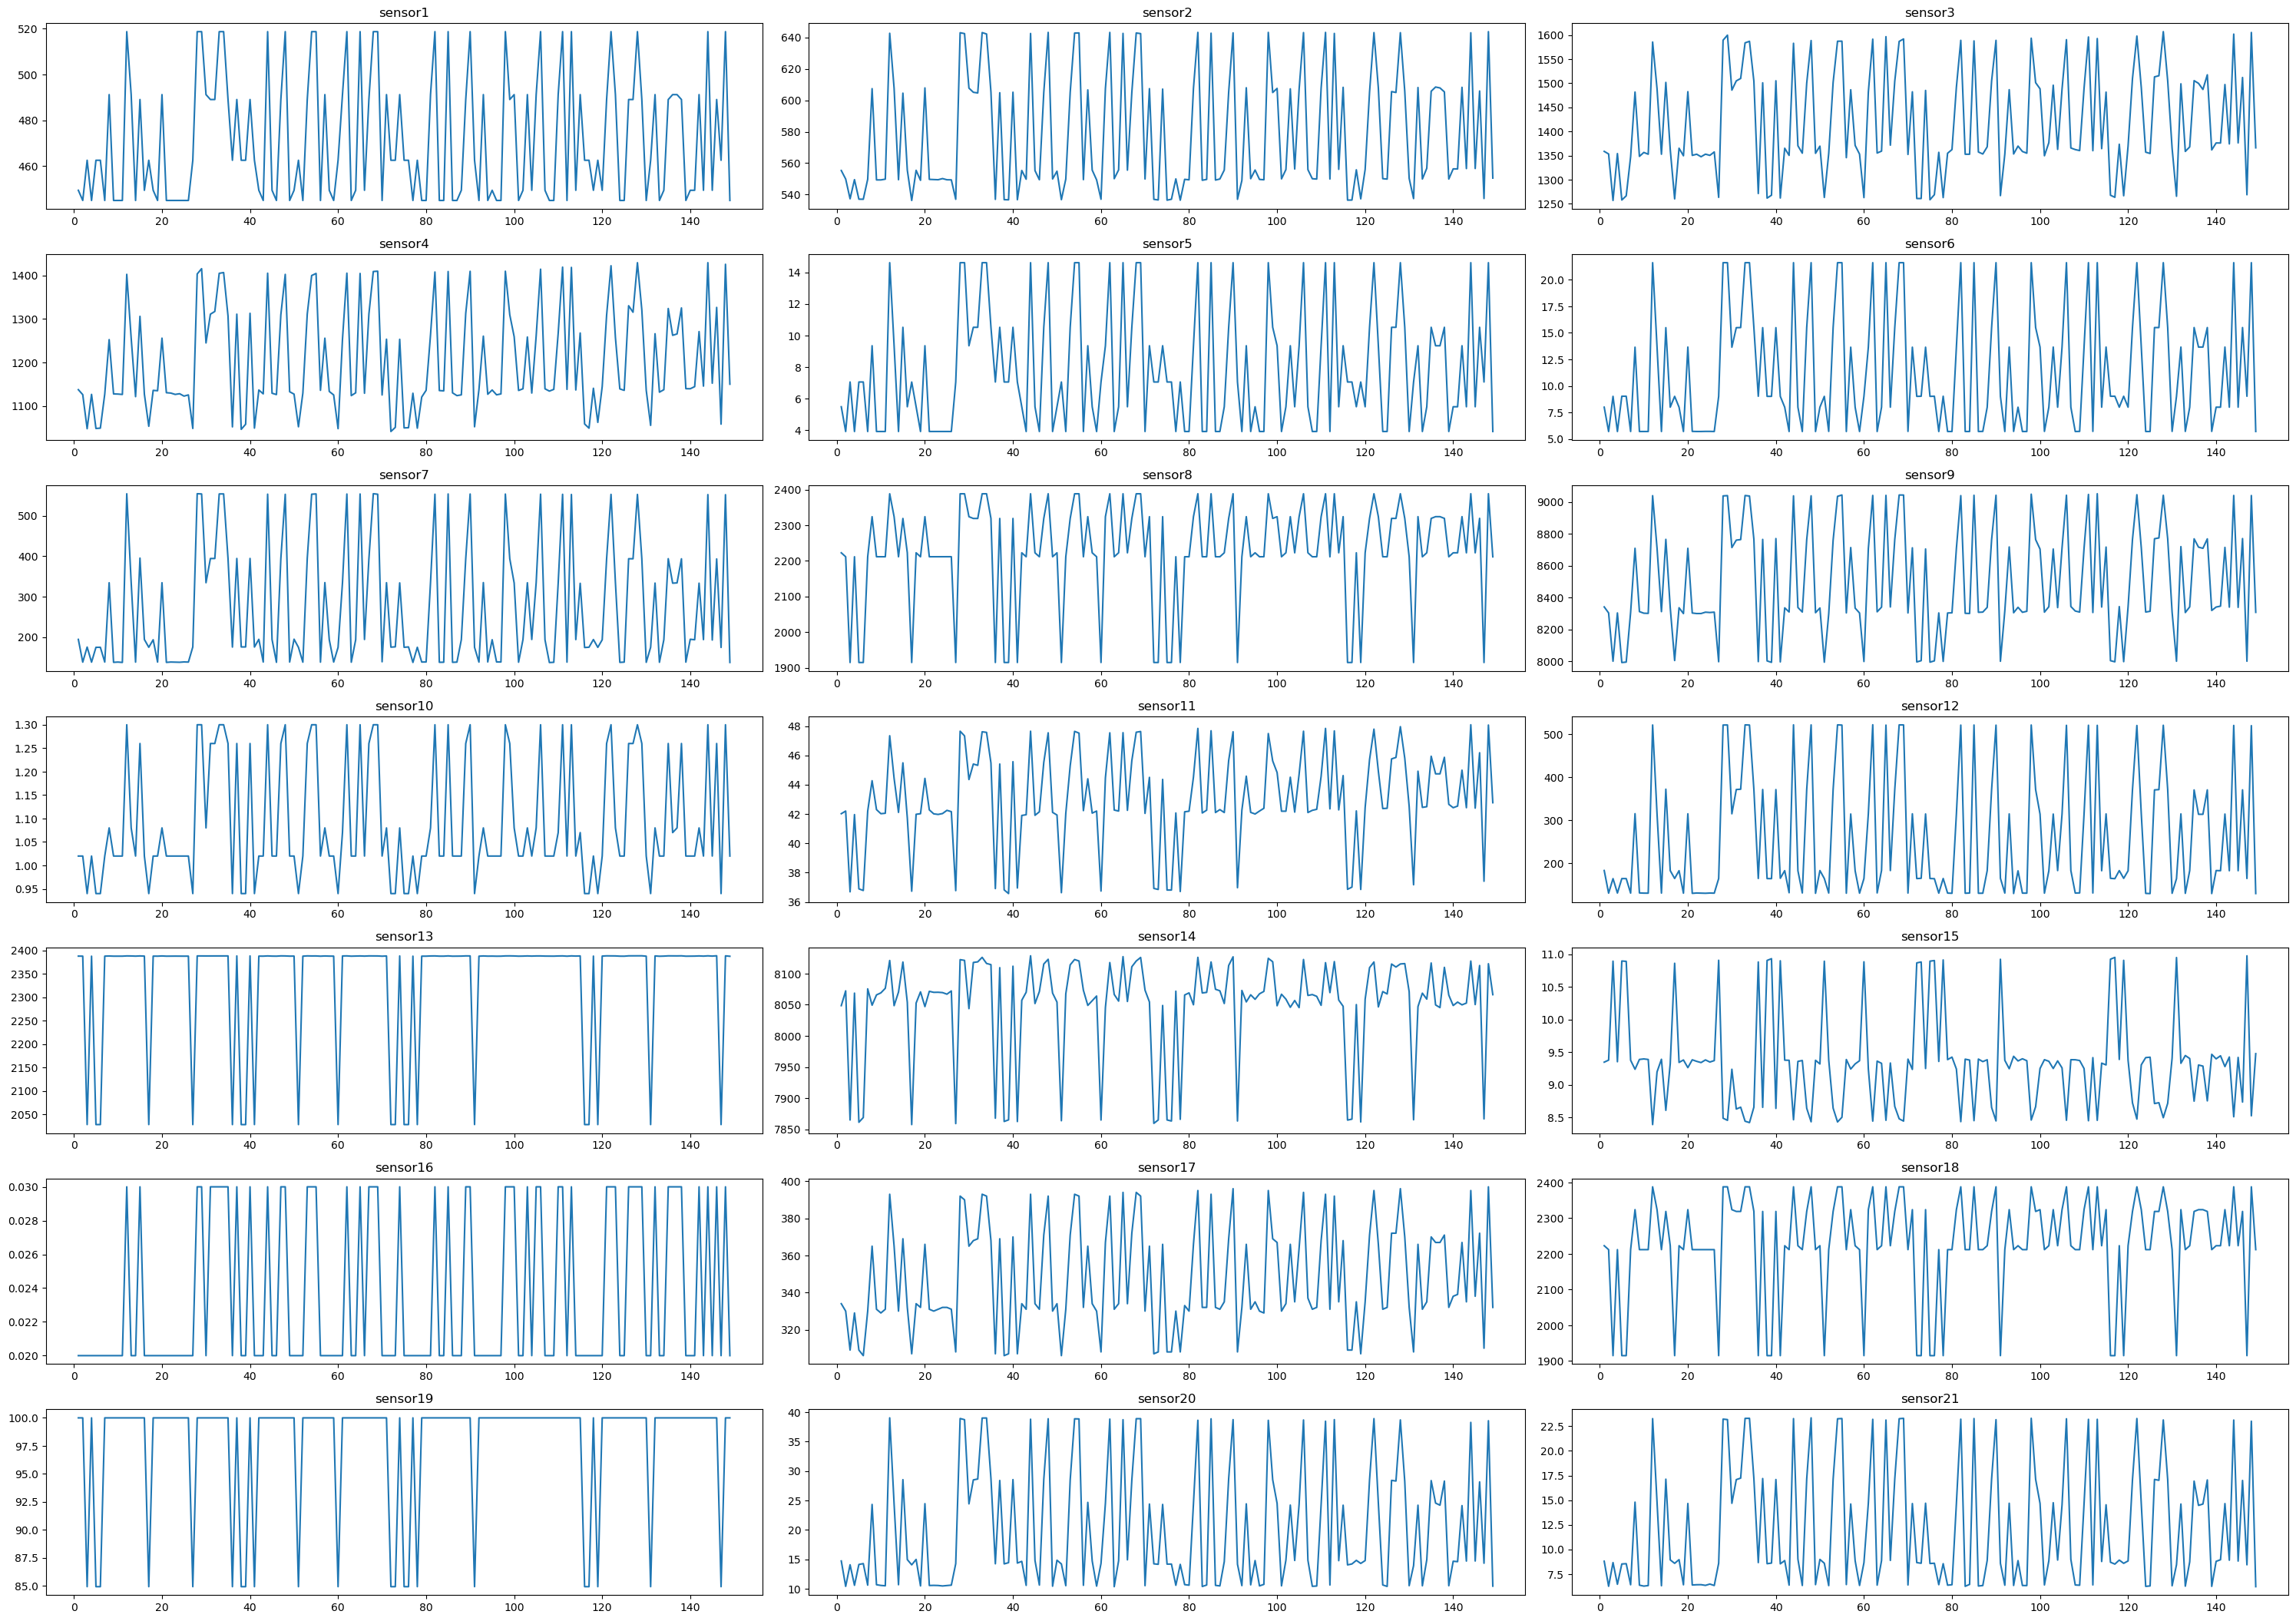

In [12]:
plotSensors(train, 1, 1,sensors)

Passiamo a stampare la distribuzione dei dati per ogni sensore e poi confrontiamo il risultato con quello che otterremo post normalizzazione. 

Lasciamo di seguito il <a href = "https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751">Link</a> alla guida per l'utilizzo di **histplot** e a come renderlo simile al deprecato *distplot*. 

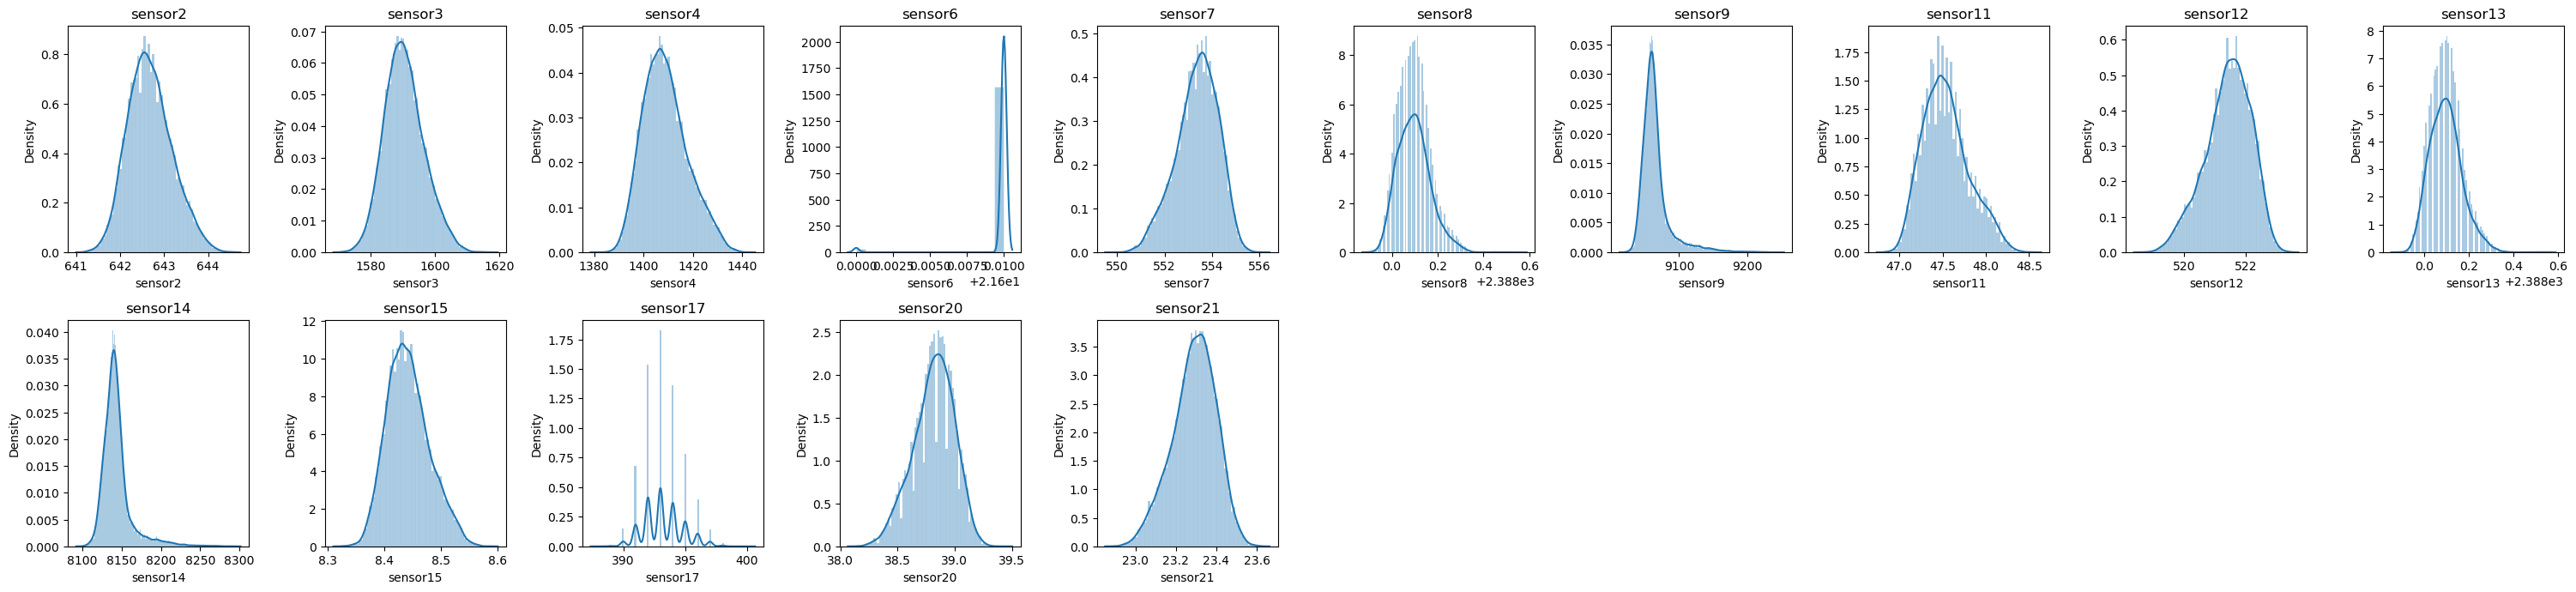

In [13]:
def plotSensorDensity(train_list,numeroDF, sensors):
    
    plt.figure(figsize=(30, 10))
    df = train_list[numeroDF]
    i = 0
    removable_sensors = []
    for sensor in sensors:
        
        if(len(df[sensor].unique()) <= 1):
            removable_sensors.append(sensor)
            continue

        plt.subplot(3, 10, i+1).set_title(sensor)
        sns.histplot(df[sensor], kde=True, stat = "density", kde_kws=dict(cut=3), 
        alpha=.4, edgecolor=(1, 1, 1, .4)) #ex distplot
        i+=1
    plt.tight_layout()
    return removable_sensors

removable_sensors = plotSensorDensity(train, 0, sensors)

Rimuoviamo quindi i seguenti sensori 
- Sensore 1
- Sensore 5
- Sensore 10
- Sensore 16
- Sensore 18
- Sensore 19

In [14]:
print(removable_sensors)

for df in train:
    df.drop(removable_sensors, inplace=True, axis=1)

train[0].head()

['sensor1', 'sensor5', 'sensor10', 'sensor16', 'sensor18', 'sensor19']


In [15]:
#Rimuoviamo dalla lista i sesori che abbiamo indiciduato
for sensor in removable_sensors: 
    sensors.remove(sensor)
print(sensors)

['sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21']


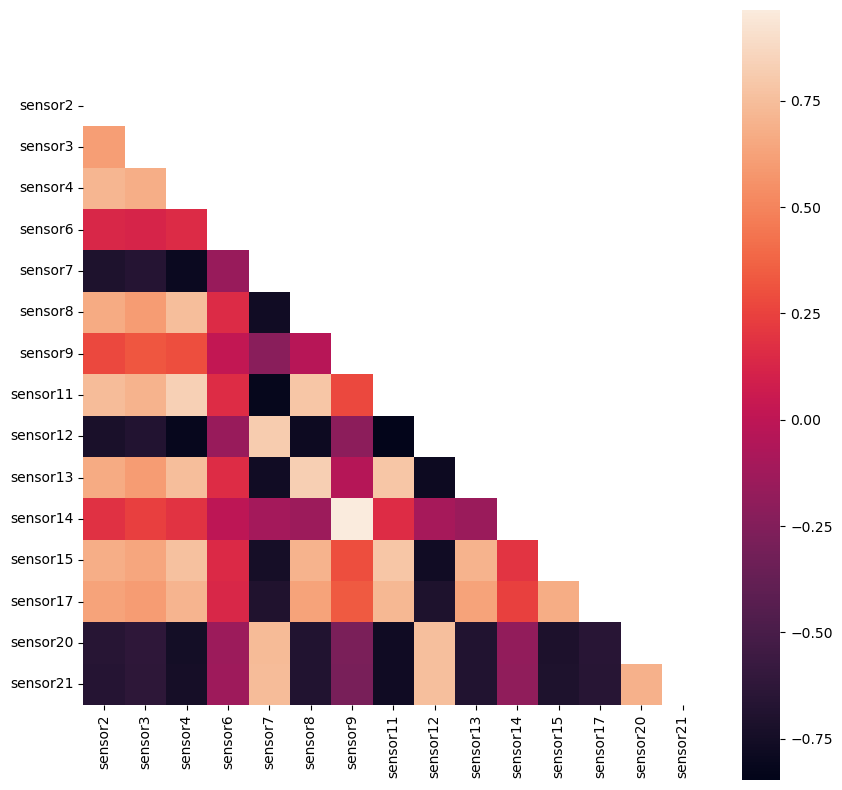

In [16]:
def plotSensorsCorrelation(train_list,numeroDF, sensors):
    df = train_list[numeroDF]
    correlation = df[sensors].corr()
    
#Queste due righe di codice servono per fare in modo di mostrare soltanto la parte bassa della matrice 
#Invece che la sua interezza dato che è simmetrica rispetto alla diagionale principale
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation, square = True, mask = mask)

plotSensorsCorrelation(train, 0, sensors)

### Min Max scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [23]:
all_columns = df.columns.tolist()
columns_to_keep = [item for item in all_columns if item not in sensors]
 
#Sensors è la nostra columns_to_scale

In [24]:
print(columns_to_keep)

['unit_number', 'time_cycle', 'op_setting1', 'op_setting2', 'op_setting3', 'sensor1', 'sensor5', 'sensor10', 'sensor16', 'sensor18', 'sensor19', 'RUL']


In [ ]:
#Utilizziamo un trasformatore per decidere di quali colonne vogliamo fare lo scaling
def dataScaling(train, numeroDF, columns_to_keep, columns_to_scale):
    df = train[numeroDF]
    scaler = MinMaxScaler() 
    transformers = [
        ('scaled', scaler, columns_to_scale),
        ('unchanged', 'passthrough', columns_to_keep)
    ]
    ct = ColumnTransformer(transformers=transformers)
    scaled_data = ct.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale + columns_to_keep)

    return scaled_df